## Машинное обучение в бизнесе
### Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

---

#### Код из урока

In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  # pip install pymorphy2
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

%matplotlib inline

In [2]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [3]:
def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст

    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]

    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

In [4]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_58040/1113034805.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 46.7 s, sys: 4.97 s, total: 51.6 s
Wall time: 59.5 s


In [5]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 46s, sys: 338 ms, total: 3min 46s
Wall time: 3min 55s


In [6]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [7]:
%%time
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 7s, sys: 2min 25s, total: 3min 33s
Wall time: 40.2 s


In [8]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)
# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [9]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.029390378),
 (2, 0.036472697),
 (8, 0.03355893),
 (9, 0.36713612),
 (12, 0.096076615),
 (17, 0.07286872),
 (23, 0.3453991)]

In [10]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: турция турецкий уточнять держава рождение пограничный передаваться
topic_1: ракета американский штат журнал тело восток исследование
topic_2: тур парк ирландия новгород калининградский литва браун
topic_3: выяснить смерть запустить иск испытание организм градус
topic_4: гражданин товар экипаж россиянин фронт народный флот
topic_5: мозг операция врач произойти тело пострадать авария
topic_6: газ статья россия путин российский экономика владимир
topic_7: всё большой россия например проблема случай расти
topic_8: украина научный украинский россия власть российский млн
topic_9: млрд цена рубль тыс рост около уровень
topic_10: фестиваль польша билет польский германия мероприятие гость
topic_11: nn место наука риск обнаружить проект первый
topic_12: автор день энергия хороший погода дождь первый
topic_13: гражданство гарантия актёр приоритетный дорого си комплексный
topic_14: продукция космос депутат технология федеральный предполагаться запуск
topic_15: банк фонд рф проверка северн

In [11]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [12]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.908342,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,4896,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.703722,0.272055,0.0
2,4897,0.029391,0.0,0.036467,0.0,0.000000,0.0,0.0,0.000000,0.033537,...,0.000000,0.0000,0.073232,0.0,0.000000,0.0,0.0,0.000000,0.345754,0.0
3,4898,0.000000,0.0,0.000000,0.0,0.031888,0.0,0.0,0.368847,0.000000,...,0.000000,0.0913,0.000000,0.0,0.262292,0.0,0.0,0.000000,0.174562,0.0
4,4899,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.069758,0.0


In [13]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [14]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [15]:
get_user_embedding(user_articles_list)

array([0.00225908, 0.05554404, 0.        , 0.00453982, 0.00558216,
       0.        , 0.15104035, 0.04934737, 0.08020597, 0.06363118,
       0.        , 0.03966878, 0.        , 0.00817027, 0.00735171,
       0.        , 0.06511856, 0.13890936, 0.02214169, 0.04747801,
       0.02136445, 0.03184371, 0.1943273 , 0.        , 0.        ])

In [16]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.024235,0.0,0.000000,0.003444,0.015331,0.045792,0.024304,0.091159,...,0.000000,0.021671,0.058718,0.008178,0.134225,0.027642,0.081697,0.175890,0.006168,0.0
1,u108690,0.0,0.029195,0.0,0.001923,0.000000,0.023225,0.077930,0.087019,0.154395,...,0.037500,0.029101,0.110055,0.007979,0.080282,0.082962,0.032918,0.102161,0.000000,0.0
2,u108339,0.0,0.043237,0.0,0.008591,0.000000,0.047694,0.044212,0.010326,0.057343,...,0.024661,0.004721,0.035508,0.062610,0.098326,0.058383,0.059666,0.220243,0.000000,0.0


In [17]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [18]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.024235,0.0,0.000000,0.003444,0.015331,0.045792,0.024304,0.091159,...,0.021671,0.058718,0.008178,0.134225,0.027642,0.081697,0.175890,0.006168,0.0,0
1,u108690,0.0,0.029195,0.0,0.001923,0.000000,0.023225,0.077930,0.087019,0.154395,...,0.029101,0.110055,0.007979,0.080282,0.082962,0.032918,0.102161,0.000000,0.0,1
2,u108339,0.0,0.043237,0.0,0.008591,0.000000,0.047694,0.044212,0.010326,0.057343,...,0.004721,0.035508,0.062610,0.098326,0.058383,0.059666,0.220243,0.000000,0.0,1


In [19]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [20]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [21]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08580058, 0.11686882, 0.24591399, 0.16367442, 0.16202633,
       0.10950459, 0.15408194, 0.11313409, 0.11172446, 0.15421473])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.194469, F-Score=0.526, Precision=0.425, Recall=0.690


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1526  229]
 [  77  168]]


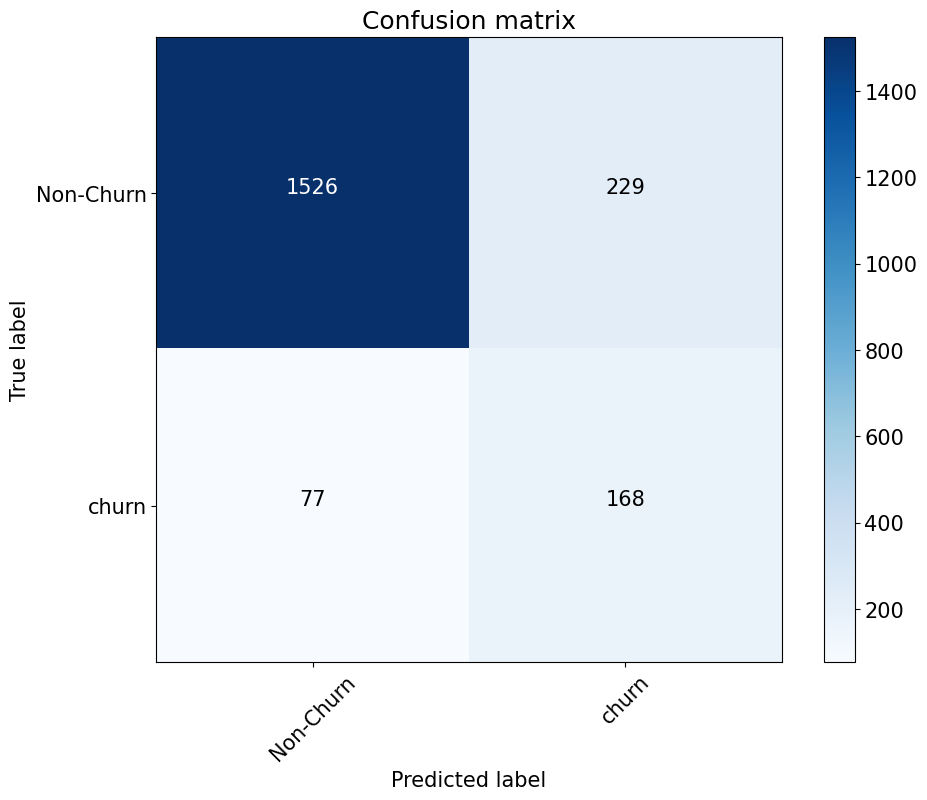

In [24]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [25]:
roc_auc_score(y_test, preds)

0.8924728181871039

---

##### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


In [26]:
def get_user_embedding_with_func(user_articles_list, avg_func=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = avg_func(user_vector, axis=0)
    return user_vector

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_with_func(x, np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.012508,0.000000,0.000000,...,0.000000,0.0,0.031422,0.000000,0.092846,0.000000,0.000000,0.172253,0.0,0.0
1,u108690,0.0,0.030733,0.0,0.000000,0.0,0.000000,0.068805,0.095057,0.118332,...,0.021151,0.0,0.062014,0.000000,0.072267,0.100496,0.030713,0.065881,0.0,0.0
2,u108339,0.0,0.039509,0.0,0.005756,0.0,0.046013,0.042265,0.000000,0.037540,...,0.009303,0.0,0.005593,0.024744,0.090946,0.054116,0.000000,0.270334,0.0,0.0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.254891, F-Score=0.736, Precision=0.697, Recall=0.780


In [29]:
roc_auc_score(y_test, preds)

0.9577696377696377

---

##### 3. Повторить п.2, но используя уже не медиану, а max


In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_with_func(x, np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.092705,0.0,0.000000,0.020667,0.091984,0.148775,0.124797,0.428234,...,0.000000,0.130026,0.182947,0.036721,0.452168,0.095514,0.374070,0.364301,0.037006,0.0
1,u108690,0.0,0.063260,0.0,0.011537,0.000000,0.119191,0.145504,0.139522,0.458822,...,0.126093,0.157605,0.303506,0.037091,0.121740,0.136024,0.068570,0.234393,0.000000,0.0
2,u108339,0.0,0.093728,0.0,0.020902,0.000000,0.097256,0.121619,0.061955,0.185359,...,0.096120,0.028325,0.169129,0.219005,0.236072,0.135421,0.208299,0.340395,0.000000,0.0


In [31]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.328111, F-Score=0.808, Precision=0.755, Recall=0.869


In [32]:
roc_auc_score(y_test, preds)

0.9768753997325427

---

##### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.



In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

cleaned_articles = []
for article in users['articles'].values:
    cleaned_articles.append(re.sub(r"[\[\],]", '', article))
tfid_vectorizer = TfidfVectorizer()
sparce_matrix = tfid_vectorizer.fit_transform(pd.DataFrame(cleaned_articles)[0])

idf = tfid_vectorizer.idf_
idf_dict = dict(zip(tfid_vectorizer.get_feature_names_out(), idf))
X = pd.DataFrame([[user] + eval(articles) for user, articles in zip(users['uid'],users['articles'])])
idf_rows = []
for row in X.iterrows():
    idf_rows.append([row[1][0]] + [idf_dict.get(str(row[1][i]),0) for i in range(1, 7)])
X = pd.DataFrame(idf_rows)
X.rename(columns={0: 'uid'}, inplace=True)
X = pd.merge(X, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[[i for i in range(1, 7)]],
                                                        X['churn'], random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_test, preds)
print(f'ROC_AUC: {roc_auc}')

tfidf_metrics = 'tfidf', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

Best Threshold=0.359564, F-Score=0.866, Precision=0.839, Recall=0.894
ROC_AUC: 0.9892005349148206


---

##### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [43]:
def get_metrics(method):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_with_func(x, method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                        X['churn'], random_state=42)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    return method.__name__, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)

In [50]:
pd.DataFrame([get_metrics(method) for method in [np.mean, np.median, np.max]]+[tfidf_metrics],
             columns=('method', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc'))

,method,thresholds,fscore,precision,recall,roc_auc
0,mean,0.185005,0.520064,0.437838,0.640316,0.877271
1,median,0.231910,0.740072,0.681063,0.810277,0.961017
2,amax,0.330387,0.806202,0.790875,0.822134,0.973226
3,tfidf,0.359564,0.865613,0.839080,0.893878,0.989201


---

##### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Если не учитывать tfidf, то лучший результат модель показывает при использовании метода max для построения вектора признаков пользователей. Видимо к этому привело то что в выборку попали самые весомые значения из-за чего и повысилась точность. Что касается tfidf векторизации можно предположить что на определение оттока пользователей чтение отдельных статей влияет больше чем тематика этих статей.